In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [497]:
import os
import numpy as np
import pandas as pd
from io import BytesIO
import tempfile
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.fits as afwFits
import lsst.geom
import lsst.alert.packet
from lsst.ap.association import UnpackApdbFlags
from lsst.utils import getPackageDir

from astropy.nddata import CCDData

This ticket was created to investigate why cutouts in alert projection are so large.

The cutout size for alerts is computed from the source footprint by computing the distance from the centroid of the DiaSource to the min/max x/y edges of the bounding box and taking 2 times the largest of these comparisons as the width of the square bounding box of the cutout. This creates a cutout that is centred at the centroid of the DiaSource and contains the full detected footprint. https://github.com/lsst/ap_association/blob/87898ef4749329fb0c47ff2995ee90c5b53f7ae5/python/lsst/ap/association/mapApData.py#L348

Some of these resulting cutouts were found to be extremely large, ~1k square pixels, almost the size of the full image. This appears to be caused by peaks that are included in the detection footprint but can be thousands of pixels away outside of the footprint itself. The centroids calculated in AP (PeakCentroid, NaiveCentroid, and SdssCentroid algorithms) end up at these peaks and thus are nowhere near the initial detection, thus creating the large cutout excursion when using the previous calculation. These peaks are not solely associated with artifacts or edge effects.

This mostly occurs for negative peaks but seems to also show up for positive peaks as well though at a much lower rate.

Below, I use g band data from the ap_verify_hits2015 dataset to investigate and reproduce the problem. I'm not sure how badly this issue is for other datasets through another ticket could be created to investigate it for say HSC-COSMOS. Visits available in the dataset are listed here: https://github.com/lsst/ap_verify_hits2015/blob/master/doc/ap_verify_hits2015/index.rst Not all of the DECam's 62 ccds are pocessed as several are known to be dead.


In [460]:
b = dafPersist.Butler("/project/morriscb/src/ap_verify_hits2015/DM-25229/output")

Grab data from the first visit/first ccd.

In [582]:
diaSrc = b.get("deepDiff_diaSrc", visit=410915, ccdnum=1)
srcCat = b.get("src", visit=410915, ccdnum=1)
diffIm = b.get("deepDiff_differenceExp", visit=410915, ccdnum=1)

Plot the detected footprints below for reference. Here, positive detections are in cyan and negative detections are in purple.

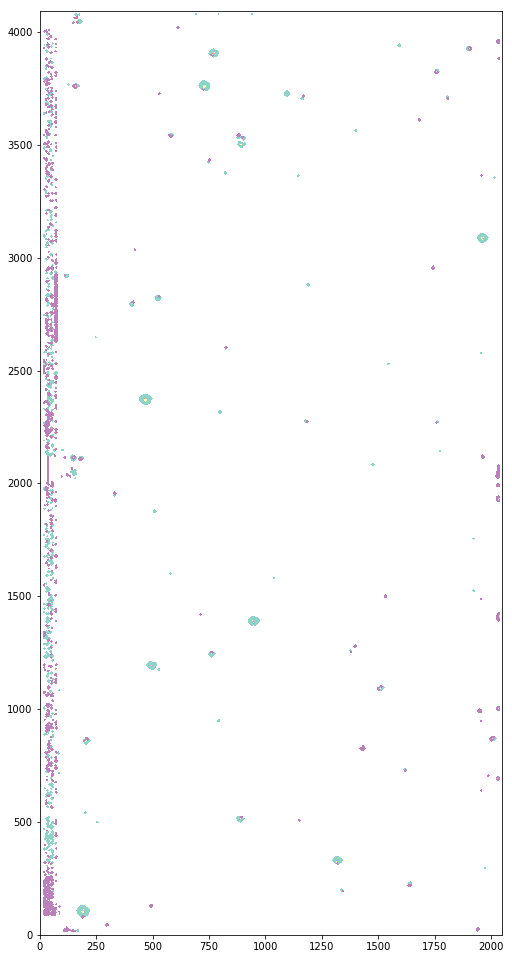

In [583]:
figure(figsize=(11 * 2, 8.5 * 2))
imshow(np.where(
         np.bitwise_and(diffIm.mask.array, 2 ** diffIm.mask.getMaskPlane("DETECTED")) > 0,
         diffIm.image.array,
         np.nan),
      origin=(0, 0),
      cmap="Set3")
imshow(np.where(
           np.bitwise_and(diffIm.mask.array, 2 ** diffIm.mask.getMaskPlane("DETECTED_NEGATIVE")) > 0,
           diffIm.image.array,
           np.nan),
      origin=(0, 0),
      cmap="Set3")

In [584]:
def test_peak_in_footprint(src):
    """Test that peaks for a given source are contained within its footprint.
    
    If the peak is outside the footprint bounding box,
    we write out identifying information of the source it is
    a part of, the id of the peak, position, flux value,
    and how far it is outside of a given box ("nan if inside").
    
    Parameters
    ----------
    src : `lsst.afw.table.SourceRecord`
        Source to test
    
    Retuns
    ------
    badPeaks : `dict`
        Dictionary of peak values.
    """
    foot = src.getFootprint()
    bbox = foot.getBBox()
    peaks = foot.getPeaks()
    badPeaks = []
    for peak in peaks:
        if not bbox.contains(peak.getFx(), peak.getFy()):
            if peak.getFx() < bbox.minX:
                dX = peak.getFx() - bbox.minX
            elif peak.getFx() > bbox.maxX:
                dX = peak.getFx() - bbox.maxX
            else:
                dX = np.nan

            if peak.getFy() < bbox.minY:
                dY = peak.getFy() - bbox.minY
            elif peak.getFy() > bbox.maxY:
                dY = peak.getFy() - bbox.maxY
            else:
                dY = np.nan

            badPeak = {"SourceId": src["id"],
                       "parent": src["parent"],
                       "PeakId": peak.getId(),
                       "Fx": peak.getFx(),
                       "Fy": peak.getFy(),
                       "Ix": peak.getIx(),
                       "Iy": peak.getIy(),
                       "value": peak.getPeakValue(),
                       "dXoutOfBBox": dX,
                       "dYoutOfBBox": dY,
                       "bboxMinX": bbox.minX,
                       "bboxMaxX": bbox.maxX,
                       "bboxMinY": bbox.minY,
                       "bboxMaxY": bbox.maxY,
                      }
            badPeaks.append(badPeak)
    return badPeaks

Loop through the detected and deblended sources from the source catalog output by ProcessCcd.calibrate. For this visit/ccd we see that there are no peaks outside of the footprint bounding boxes and the centroids calculated in the pipeline are all within the bounding box as well.

In [585]:
print("Total sources", len(srcCat))
peak = 0
naive = 0
sdss = 0
dipole = 0
posBadPeaks = []
for src in srcCat:
    posBadPeaks.extend(test_peak_in_footprint(src))
    if not src.getFootprint().getBBox().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_NaiveCentroid_x"],
                                                                                     src["base_NaiveCentroid_y"]))):
        naive += 1
    if not src.getFootprint().getBBox().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_SdssCentroid_x"],
                                                                                     src["base_SdssCentroid_y"]))):
        sdss += 1
print("N Naive cent bad:", naive)
print("N Sdss cent bad:", sdss)
posBadPeaks = pd.DataFrame(data=posBadPeaks)
print("N bad peaks:", len(posBadPeaks))

Total sources 1732
N Naive cent bad: 0
N Sdss cent bad: 0
N bad peaks: 0


Loop the DiaSources produced by ImageDifferenceTask and its associated detection/measurement taks. Here we see that many of the centroids measured are outside of the footprint, and the peaks that make up their detection footprint can also be found outside of the footprint bounding box.

Interestingly, one peak (378940), can be seen as included in more than one source footprint. This might be expected behavior (as in I'm not sure) but the peak is outside for both footprints. The footprints themselves also do not overlap as evidenced by their min/max X of their bounding box.

In [586]:
print("Total DiaSources", len(diaSrc))
peak = 0
naive = 0
sdss = 0
dipole = 0
negBadPeaks = []
for src in diaSrc:
    negBadPeaks.extend(test_peak_in_footprint(src))
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_PeakCentroid_x"],
                                                                           src["base_PeakCentroid_y"]))):
        peak += 1
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_NaiveCentroid_x"],
                                                                           src["base_NaiveCentroid_y"]))):
        naive += 1
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_SdssCentroid_x"],
                                                                           src["base_SdssCentroid_y"]))):
        sdss += 1
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["ip_diffim_NaiveDipoleCentroid_x"],
                                                                           src["ip_diffim_NaiveDipoleCentroid_y"]))):
        dipole += 1
print("N Peak cent bad", peak)
print("N Naive cent bad:", naive)
print("N Sdss cent bad:", sdss)
print("N NaiveDipole cent bad", dipole)
negBadPeaks = pd.DataFrame(data=negBadPeaks)
print("N bad peaks:", len(negBadPeaks))
negBadPeaks.set_index(["PeakId"], inplace=True, drop=False)
negBadPeaks.sort_index()

Total DiaSources 203
N Peak cent bad 6
N Naive cent bad: 2
N Sdss cent bad: 14
N NaiveDipole cent bad 16
N bad peaks: 28


,SourceId,parent,PeakId,Fx,Fy,Ix,Iy,value,dXoutOfBBox,dYoutOfBBox,bboxMinX,bboxMaxX,bboxMinY,bboxMaxY
PeakId,,,,,,,,,,,,,,
378835,176486652938551899,0,378835,1951.0,639.0,1951,639,-5.988333,1871.0,NaN,11,80,556,951
378836,176486652938551887,0,378836,71.0,647.0,71,647,-5.867034,NaN,-20.0,62,78,667,684
378868,176486652938551896,0,378868,71.0,809.0,71,809,-6.585782,-1339.0,-3.0,1410,1441,812,843
378900,176486652938551905,0,378900,70.0,977.0,70,977,-7.578612,-1861.0,-3.0,1931,1956,980,1005
378908,176486652938551909,0,378908,36.0,1011.0,36,1011,-6.010190,-12.0,-18.0,48,64,1029,1045
378910,176486652938551909,0,378910,29.0,1017.0,29,1017,-6.626840,-19.0,-12.0,48,64,1029,1045
378911,176486652938551909,0,378911,39.0,1023.0,39,1023,-6.302304,-9.0,-6.0,48,64,1029,1045
378912,176486652938551909,0,378912,30.0,1024.0,30,1024,-5.415693,-18.0,-5.0,48,64,1029,1045
378919,176486652938551912,0,378919,17.0,1072.0,17,1072,-14.618939,-1471.0,-5.0,1488,1525,1077,1108


Now we show another CCD/visit that I mostly picked at random.

In [587]:
diaSrc = b.get("deepDiff_diaSrc", visit=412520, ccdnum=25)
srcCat = b.get("src", visit=412520, ccdnum=25)
diffIm = b.get("deepDiff_differenceExp", visit=412520, ccdnum=25)

Here we see that there are positive peaks that are found to be outside of the detection bounding box. However, most of this seems to be that their bounding box is undefined as they are deblended objects as shown by their parentId being set. There is one peak though that is found to be outside of the detection footprint bounding box by 11 pixels in the y direction. Jumping around randomly through the ccdVisit's available, such a case seems to be a rare occurrence compared to the negative peaks but can happen from time to time.

In [588]:
print("Total sources", len(srcCat))
peak = 0
naive = 0
sdss = 0
dipole = 0
posBadPeaks = []
for src in srcCat:
    posBadPeaks.extend(test_peak_in_footprint(src))
    if not src.getFootprint().getBBox().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_NaiveCentroid_x"],
                                                                                     src["base_NaiveCentroid_y"]))):
        naive += 1
    if not src.getFootprint().getBBox().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_SdssCentroid_x"],
                                                                                     src["base_SdssCentroid_y"]))):
        sdss += 1
print("N Naive cent bad:", naive)
print("N Sdss cent bad:", sdss)
posBadPeaks = pd.DataFrame(data=posBadPeaks)
print("N bad peaks:", len(posBadPeaks))
posBadPeaks.set_index(["PeakId"], inplace=True, drop=False)
posBadPeaks.sort_index()

Total sources 1235
N Naive cent bad: 9
N Sdss cent bad: 9
N bad peaks: 10


,SourceId,parent,PeakId,Fx,Fy,Ix,Iy,value,dXoutOfBBox,dYoutOfBBox,bboxMinX,bboxMaxX,bboxMinY,bboxMaxY
PeakId,,,,,,,,,,,,,,
2788670,177176098268775403,177176098268774639,2788670,356.0,1250.0,356,1250,7.156794,357.0,1251.0,0,-1,0,-1
2788672,177176098268775401,177176098268774639,2788672,356.0,1274.0,356,1274,8.107275,357.0,1275.0,0,-1,0,-1
2788673,177176098268775399,177176098268774639,2788673,356.0,1285.0,356,1285,8.680075,357.0,1286.0,0,-1,0,-1
2788674,177176098268775398,177176098268774639,2788674,356.0,1291.0,356,1291,8.683245,357.0,1292.0,0,-1,0,-1
2788676,177176098268775395,177176098268774639,2788676,356.0,1310.0,356,1310,9.513031,357.0,1311.0,0,-1,0,-1
2788681,177176098268775396,177176098268774639,2788681,356.0,1377.0,356,1377,9.381834,357.0,1378.0,0,-1,0,-1
2788683,177176098268775393,177176098268774639,2788683,356.0,1407.0,356,1407,9.952892,357.0,1408.0,0,-1,0,-1
2788684,177176098268775391,177176098268774639,2788684,356.0,1424.0,356,1424,10.487937,357.0,1425.0,0,-1,0,-1
2788685,177176098268774639,0,2788685,356.0,1435.0,356,1435,10.313160,NaN,11.0,328,402,1216,1424


In [589]:
print("Total DiaSources", len(diaSrc))
peak = 0
naive = 0
sdss = 0
dipole = 0
negBadPeaks = []
for src in diaSrc:
    negBadPeaks.extend(test_peak_in_footprint(src))
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_PeakCentroid_x"],
                                                                           src["base_PeakCentroid_y"]))):
        peak += 1
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_NaiveCentroid_x"],
                                                                           src["base_NaiveCentroid_y"]))):
        naive += 1
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["base_SdssCentroid_x"],
                                                                           src["base_SdssCentroid_y"]))):
        sdss += 1
    if not src.getFootprint().contains(lsst.geom.Point2I(lsst.geom.Point2D(src["ip_diffim_NaiveDipoleCentroid_x"],
                                                                           src["ip_diffim_NaiveDipoleCentroid_y"]))):
        dipole += 1
print("N Peak cent bad", peak)
print("N Naive cent bad:", naive)
print("N Sdss cent bad:", sdss)
print("N NaiveDipole cent bad", dipole)
negBadPeaks = pd.DataFrame(data=negBadPeaks)
print("N bad peaks:", len(negBadPeaks))
negBadPeaks.set_index(["PeakId"], inplace=True, drop=False)
negBadPeaks.sort_index()

Total DiaSources 175
N Peak cent bad 1
N Naive cent bad: 0
N Sdss cent bad: 3
N NaiveDipole cent bad 3
N bad peaks: 7


,SourceId,parent,PeakId,Fx,Fy,Ix,Iy,value,dXoutOfBBox,dYoutOfBBox,bboxMinX,bboxMaxX,bboxMinY,bboxMaxY
PeakId,,,,,,,,,,,,,,
2791761,177176098268774723,0,2791761,45.0,1946.0,45,1946,-4.626263,NaN,-41.0,36,57,1987,2020
2791812,177176098268774775,0,2791812,38.0,3451.0,38,3451,-6.679232,-6.0,-125.0,44,60,3576,3592
2791813,177176098268774775,0,2791813,47.0,3456.0,47,3456,-6.059445,NaN,-120.0,44,60,3576,3592
2791814,177176098268774775,0,2791814,40.0,3461.0,40,3461,-4.663498,-4.0,-115.0,44,60,3576,3592
2791815,177176098268774775,0,2791815,49.0,3476.0,49,3476,-5.490201,NaN,-100.0,44,60,3576,3592
2791816,177176098268774774,0,2791816,47.0,3509.0,47,3509,-4.980130,NaN,-40.0,38,54,3549,3565
2791896,177176098268774774,0,2791896,43.0,3533.0,43,3533,-5.354991,NaN,-16.0,38,54,3549,3565


Not as bad as the first CCD we looked at but still significant with at least 3 centroids outside of the their footprint bounding boxes and more than a few peaks being 100s of pixels out of the bounding box.